Order=(0, 0, 0) AIC=-6.086
Order=(0, 0, 1) AIC=-7.129
Order=(0, 0, 2) AIC=-3.948
Order=(0, 1, 0) AIC=-2.030
Order=(0, 1, 1) AIC=-1.821
Order=(0, 1, 2) AIC=-3.648
Order=(1, 0, 0) AIC=-4.093
Order=(1, 0, 1) AIC=-5.243
Order=(1, 0, 2) AIC=-6.128
Order=(1, 1, 0) AIC=-0.033
Order=(1, 1, 1) AIC=-0.186
Order=(1, 1, 2) AIC=-1.648
Order=(2, 0, 0) AIC=-15.639
Order=(2, 0, 1) AIC=-15.417
Order=(2, 0, 2) AIC=-17.083
Order=(2, 1, 0) AIC=-17.726
Order=(2, 1, 1) AIC=-15.972
Order=(2, 1, 2) AIC=2527.412
Selected order: (2, 1, 0) (AIC=-17.726)


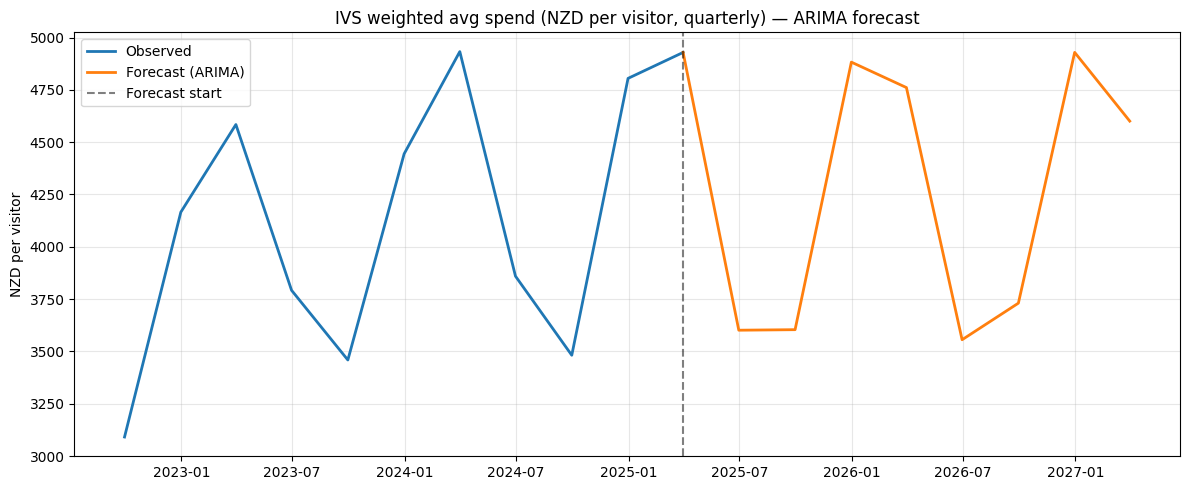

[OOS accuracy] Window: 2024-12-31 → 2025-03-31 | order=(2, 1, 0)
  RMSE : 289.501
  MAE  : 215.520
  MAPE : 4.480%
  sMAPE: 4.669%

Forecast results saved to: ../output/Model_03_ARIMA_IVS_AvgSpend.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- IVS: micro -> quarterly weighted avg spend
ivs = pd.read_csv("../datasets/visitor_survey.csv", parse_dates=["date"])
ivs = ivs[["date", "treated_spend", "vem_pop_weight"]].dropna()
ivs["quarter"] = ivs["date"].dt.to_period("Q").dt.to_timestamp("Q")

ivs_q = (
    ivs.groupby("quarter")
    .apply(lambda g: (g["treated_spend"] * g["vem_pop_weight"]).sum() / g["vem_pop_weight"].sum())
    .rename("ivs_avg_spend")
    .to_frame()
)

# --- Use quarterly grid, prune short history
df_q = ivs_q.asfreq("Q-DEC")
df_q = df_q[df_q.index >= "2022-06-30"]

if len(df_q) < 8:
    raise ValueError(f"Too few quarterly observations: {len(df_q)}. Need ~8+ for ARIMA.")

# --- log transform for stability
y_log = np.log1p(df_q["ivs_avg_spend"])

# --- Forecast horizon
h = 8
train = y_log.copy()

# --- Simple lag order search by AIC
aic_table = []
candidates = [(p,d,q) for p in range(0,3) for d in [0,1] for q in range(0,3)]
for order in candidates:
    try:
        res_try = ARIMA(train, order=order).fit()
        if np.isfinite(res_try.aic):
            aic_table.append((order, res_try.aic))
            print(f"Order={order} AIC={res_try.aic:.3f}")
    except Exception:
        pass

if aic_table:
    best_order, best_aic = min(aic_table, key=lambda x: x[1])
    res = ARIMA(train, order=best_order).fit()
    print(f"Selected order: {best_order} (AIC={best_aic:.3f})")
else:
    best_order = (1,1,1)
    res = ARIMA(train, order=best_order).fit()
    print("Fallback ARIMA(1,1,1)")

# --- Forecast
fc_log = res.get_forecast(steps=h)
fc_idx = pd.date_range(df_q.index[-1] + pd.offsets.QuarterEnd(1), periods=h, freq="Q-DEC")

fc_df_log = pd.DataFrame(fc_log.predicted_mean.values, index=fc_idx, columns=["ivs_avg_spend"])
fc_df = np.expm1(fc_df_log).clip(lower=0)

# --- Plot
plt.figure(figsize=(12,5))
plt.plot(df_q.index, df_q["ivs_avg_spend"], label="Observed", linewidth=2)
fc_line = pd.concat([df_q["ivs_avg_spend"].iloc[[-1]], fc_df["ivs_avg_spend"]])
plt.plot(fc_line.index, fc_line.values, label="Forecast (ARIMA)", linewidth=2)
plt.axvline(df_q.index[-1], color="k", linestyle="--", alpha=0.5, label="Forecast start")
plt.title("IVS weighted avg spend (NZD per visitor, quarterly) — ARIMA forecast")
plt.ylabel("NZD per visitor")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# --- Accuracy metrics
def _rmse(a, f):  return float(np.sqrt(np.mean((f - a) ** 2)))
def _mae(a, f):   return float(np.mean(np.abs(f - a)))
def _mape(a, f):
    mask = a != 0
    return float(np.mean(np.abs((f[mask] - a[mask]) / a[mask])) * 100.0) if mask.any() else np.nan
def _smape(a, f):
    denom = (np.abs(a) + np.abs(f)); mask = denom != 0
    return float(np.mean(2.0 * np.abs(f[mask] - a[mask]) / denom[mask]) * 100.0) if mask.any() else np.nan

# Hold-out (last 4 quarters)
holdout = min(4, max(2, len(df_q)//4))
y_train, y_test = y_log.iloc[:-holdout], df_q.iloc[-holdout:]

# Refit on train
res_oos = ARIMA(y_train, order=best_order).fit()
fc_oos_log = res_oos.get_forecast(steps=holdout)
fc_oos = np.expm1(fc_oos_log.predicted_mean).clip(lower=0)
fc_oos.index = y_test.index

# Metrics
a, f = y_test["ivs_avg_spend"].astype(float).values, fc_oos.values
print(f"[OOS accuracy] Window: {y_test.index[0].date()} → {y_test.index[-1].date()} | order={best_order}")
print(f"  RMSE : {_rmse(a,f):,.3f}")
print(f"  MAE  : {_mae(a,f):,.3f}")
print(f"  MAPE : {_mape(a,f):.3f}%")
print(f"  sMAPE: {_smape(a,f):.3f}%")

# --- Save forecast results
out = pd.DataFrame({"Forecast": fc_df["ivs_avg_spend"]})
out.index.name = "Date"
out_csv = "../output/Model_03_ARIMA_IVS_AvgSpend.csv"
out.to_csv(out_csv)
print(f"\nForecast results saved to: {out_csv}")
